# Data Cleaning and Sentiment Analysis
Source: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

In [1]:
import os
import json
import time
import requests
import datetime
import dateutil
import numpy as np
import pandas as pd
import glob
import string, re
import nltk
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download("vader_lexicon")
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read in the articles csv
articles = pd.read_csv("./headlines/NYTData.csv")
articles = articles.drop(columns=["doc_type", "material_type", "section", "keywords"])
articles = articles.dropna()

In [3]:
# How to check is a word is in the dataframe
# 'Adele' in names.names.values
# Create the different candidate/party dataframes
articlesR = (articles["headline"].str.contains("Trump|GOP|Republican|Pence"))
articlesR.fillna(False, inplace=True)
articlesD = (articles["headline"].str.contains("Biden|Progressive|Democrat|Harris"))
articlesD.fillna(False, inplace=True)
articlesR = articles[articlesR]
articlesD = articles[articlesD]
articlesD = articlesD[articlesD["headline"].str.contains("Trump") == False]
articlesR = articlesR[articlesR["headline"].str.contains("Biden") == False]
articlesR = articlesR.reset_index().drop(columns="index")
articlesD = articlesD.reset_index().drop(columns="index")

In [4]:
#Removing punctuation from headlines
def removePunctuation(headline):
    text = headline.translate(str.maketrans('', '', string.punctuation)).lower()
    text = text.replace("‘","")
    text = text.replace("’","")
    text = text.replace("trump", "Trump")
    text = text.replace("Trumps", "Trump")
    return text

def groupByDate(articles):
    articles = articles.groupby(["date"]).agg(lambda s: " ".join(s))
    return articles

def tokenize(headlines):
    return headlines.apply(lambda s: word_tokenize(s))

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    from https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
    
    '''
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def all_words_generator(tokenslst):
    for tokens in tokenslst:
        for token in tokens:
            yield token
 
sid = SentimentIntensityAnalyzer()
def get_compound_sentiment_score(sentence):
    ss = sid.polarity_scores(sentence)
    return ss["compound"]

def get_all_sentiment_score(sentence):
    ss = sid.polarity_scores(sentence)
    return ss

In [5]:
#Get sentiment scores
articlesD["sentiment score"] = articlesD["headline"].apply(lambda headline: get_compound_sentiment_score(headline))
articlesR["sentiment score"] = articlesR["headline"].apply(lambda headline: get_compound_sentiment_score(headline))

In [6]:
avg_daily_sent_dem = articlesD.groupby("date").mean()
avg_daily_sent_rep =articlesR.groupby("date").mean()

In [15]:
# Tokenize the data and remove punctuation
articlesR["headline"] = articlesR["headline"].apply(removePunctuation)
articlesD["headline"] = articlesD["headline"].apply(removePunctuation)
articlesR["tokens"] = tokenize(articlesR["headline"])
articlesD["tokens"] = tokenize(articlesD["headline"])
# removePunctuation(articlesR["headline"][0]) #Verify that the data look good
articlesD.tail()

,headline,date,sentiment score,tokens
1774,recount in two wisconsin counties reinforces b...,2020-11-29,0.0000,"[recount, two, wisconsin, county, reinforce, b..."
1775,bidens doctor says presidentelect has hairline...,2020-11-29,0.2023,"[bidens, doctor, presidentelect, hairline, fra..."
1776,biden expected to name top economic officials ...,2020-11-29,0.2023,"[biden, expect, name, top, economic, official,..."
1777,republicans and democrats need to work togethe...,2020-11-29,0.4019,"[republican, democrat, need, work, together, e..."
1778,jennifer psaki to be press secretary as biden ...,2020-11-29,0.0000,"[jennifer, psaki, press, secretary, biden, nam..."


In [8]:
#Lemmatize each headline
stop_words = stopwords.words("english") + ["say"]
articlesD["tokens"] = articlesD["tokens"].apply(lambda s: remove_noise(s, stop_words))
articlesR["tokens"] = articlesR["tokens"].apply(lambda s: remove_noise(s, stop_words))


In [9]:
# Generate the frequency lists for both sets
demFreqList = FreqDist(all_words_generator(articlesD["tokens"].tolist()))
repFreqList = FreqDist(all_words_generator(articlesR["tokens"].tolist()))

In [21]:
# Plot top 10 frequency words for both
rep = repFreqList.most_common(10)
dem = demFreqList.most_common(10)
rep[8] = ('pence', 105)

In [11]:
#Removing duplicate words from headlines and counting them
# for i in range(len(articles)):
#     s = {}
#     for name in nameSet:
#         if name in articles["headline"][i]:
#             if name in s:
#                 s[name] += 1
#             else:
#                 s[name] = 1
#             articles["headline"][i].replace(name, "")
#     for name in locationSet:
#         if name in articles["headline"][i]:
#             if name in s:
#                 s[name] += 1
#             else:
#                 s[name] = 1
#             articles["headline"][i].replace(name, "")
#     for word in articles["headline"][i].split():
#         word = word.replace("‘", "")
#         word = word.replace("’", "")
#         if word in s:
#             s[word] += 1
#         else:
#             s[word] = 1
#     articles["headline"][i] = s
# articles.to_csv("./data/NYTDataCleaned.csv")

sentiment score   -0.052608
dtype: float64


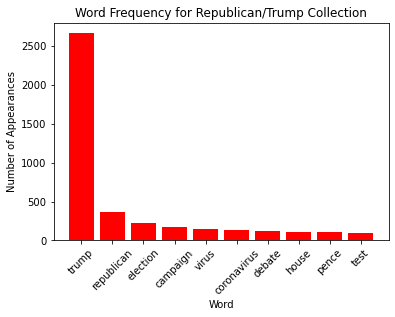

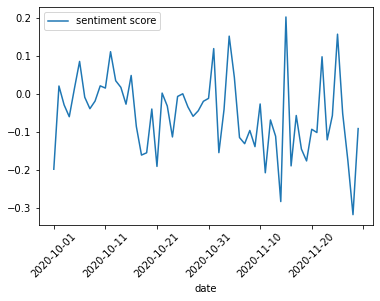

In [22]:
# Rep plot
plt.bar(*zip(*dict(rep).items()), color="red")
plt.xticks(rotation=45)
plt.title("Word Frequency for Republican/Trump Collection")
plt.xlabel("Word")
plt.ylabel("Number of Appearances")

avg_daily_sent_rep.plot()
plt.xticks(rotation=45)

print(avg_daily_sent_rep.mean())

sentiment score    0.050308
dtype: float64


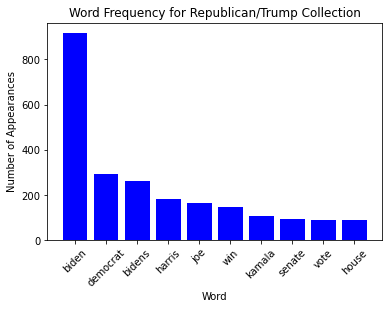

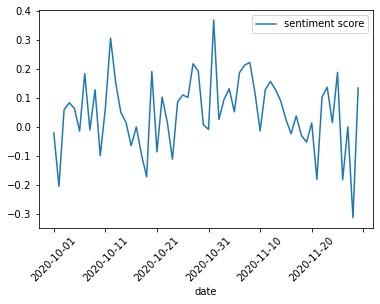

In [16]:
# Dem plot
plt.bar(*zip(*dict(dem).items()), color="blue")
plt.xticks(rotation=45)
plt.title("Word Frequency for Republican/Trump Collection")
plt.xlabel("Word")
plt.ylabel("Number of Appearances")

avg_daily_sent_dem.plot()
plt.xticks(rotation=45)
print(avg_daily_sent_dem.mean())

In [14]:
articlesD.to_csv("./data/ArticlesD.csv")
articlesR.to_csv("./data/ArticlesR.csv")
avg_daily_sent_dem.to_csv("./Data/DailyDem.csv")
avg_daily_sent_rep.to_csv("./Data/DailyRep.csv")